In [1]:
%matplotlib inline
from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

In [2]:
def dist(a, b):
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

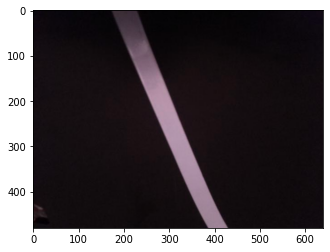

In [3]:
# img_path = '/home/michal/orig.jpg'
# img_path = '/home/michal/robots/hex/src/line_detection/line_detection/orig.jpg'
img_path = '/home/michal/robots/hex/src/line_detection/line_detection/wb.jpg'
img = cv2.imread(img_path)
plt.imshow(img)
# plt.savefig('/home/michal/studia/inz/imgs/detect_orig.png', dpi=300)

To gray, elapsed: 0.241ms


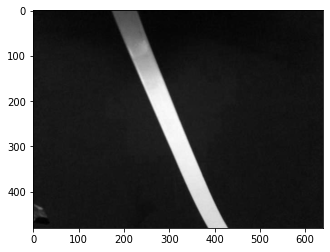

In [8]:
start = time()
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
stop = time()
print(f"To gray, elapsed: {1000 * (stop - start):.3f}ms")
plt.imshow(gray, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_gray.png', dpi=300)

Threshold, elapsed: 0.932ms


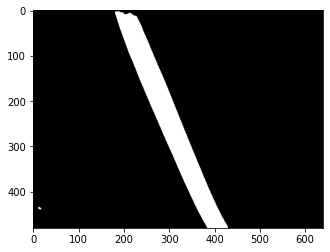

In [26]:
start = time()
# bw = gray < 50
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
stop = time()
print(f"Threshold, elapsed: {1000 * (stop - start):.3f}ms")
plt.imshow(bw, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_threshold.png', dpi=300)

Contour, elapsed: 4.624ms


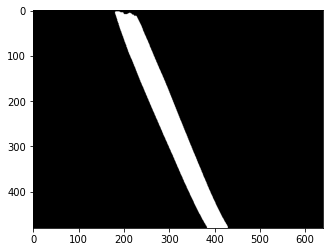

In [27]:
start = time()
cont, hier = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
c = max(cont, key=cv2.contourArea)
output = np.zeros((480, 640), dtype=np.uint8)
cv2.drawContours(output, [c], -1, 1, thickness=cv2.FILLED)
stop = time()
print(f"Contour, elapsed: {1000 * (stop - start):.3f}ms")
# cv2.fillPoly(output, c, color=(255, 0, 0))
plt.imshow(output, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_cont.png', dpi=300)
# plt.imshow(output)

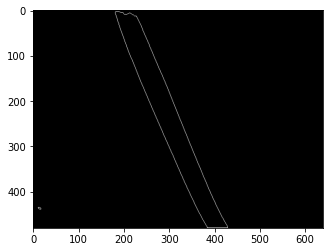

In [28]:
output = np.zeros((480, 640), dtype=np.uint8)
cv2.drawContours(output, cont, -1, 1, thickness=1)
plt.imshow(output, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_all_cont.png', dpi=300)

Skeletonize, elapse: 2.550ms


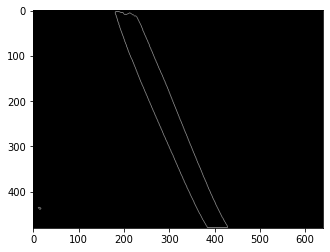

In [29]:
start = time()
skeleton = skeletonize(output, method='zhang')  # ~17ms

stop = time()
print(f'Skeletonize, elapse: {1000 * (stop - start):.3f}ms')
plt.imshow(skeleton, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_skeleton.png', dpi=300)

In [19]:
# Skeletonization not needed? we can just follow contour, it is faster
# and guaranteed to be single line
g = c.reshape((c.shape[0], 2))
top = g[:,1] == np.max(g[:,1], axis=0)
line_start = np.nonzero(g[top, 0] == np.min(g[top, 0], axis=0))[0][0]
line_dir = 1 if g[line_start + 1, 1] > g[line_start, 1] else -1
line_shifted = np.roll(g, -line_start)
path = line_shifted
line = path

In [20]:
M = np.array([
    [ 5.70452907e-06, -6.75229993e-05,  1.29731760e-01],
    [ 1.93568288e-04,  8.65877739e-06, -6.43934523e-02],
    [ 5.80038158e-05, -1.88159703e-03,  1.00000000e+00]
], dtype='float64')
path = cv2.perspectiveTransform(line_shifted.reshape((len(g), 1, 2)).astype('float64'), M)
path = path.reshape((len(path), 2))

In [21]:
LEN_THRESHOLD = 0.2
total_len = 0.0
i = 1
while total_len < LEN_THRESHOLD:
    total_len += dist(path[i - 1], path[i])
    i += 1
    if i >= len(path):
        break

line_end = i
line = line_shifted[:line_end]

In [16]:
line_start = min(np.where(g[:,1] == np.max(g[:,1], axis=0))[0])
line_len = g.shape[0] // 4
line_end = line_start + line_len
line = g[line_start:line_end]

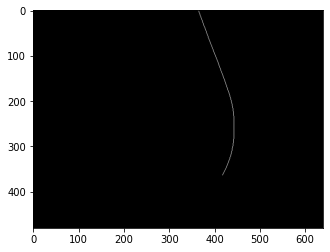

In [23]:

tmp = np.zeros((480, 640), dtype=np.uint8)
for i, j in line:
    tmp[j, i] = 1
# cv2.drawContours(tmp, [line], -1, 1, thickness=5)
plt.imshow(tmp, cmap='binary_r')
# plt.savefig('/home/michal/studia/inz/imgs/detect_line_cont.png', dpi=300)